### 머신러닝기반데이터분석 2분반 기말고사 5조
##### 데이터사이언스학과 김수아, 박서진, 오서연

### _Don't PERget Me_: 여행지 분위기 기반 머신러닝 향수 추천 시스템 프로젝트

---
0. 문제정의하기(Problem Define)
1. 라이브러리 불러오기(Libraries Setting)
2. 데이터 수집하기(Data Collection)
3. 데이터 탐색하기(Data Exploration)
4. 전처리하기(Preprocessing)
5. 모델링하기(Modeling)
    - 5.1 여행지 분위기 키워드 추출 (by. NMF)
    - 5.2 키워드와 향수 노트 유사도 측정
---

#### 0. 문제정의하기(Problem Define)

#### 1. 라이브러리 불러오기(Libraries Setting)

In [6]:
# 라이브러리 임포트
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

#### 2. 데이터 수집하기
- 데이터 경로를 통해 csv 파일 데이터 프레임화

In [3]:
# 데이터 파일 경로 설정
destination_file_path = '../Data/Prompting/dataset/destination_mood.csv'
perfume_file_path = '../Data/preprocess-data/final_perfume-info.csv'

destinations = pd.read_csv(destination_file_path)
perfumes_raw = pd.read_csv(perfume_file_path)

In [15]:
# 여행지 데이터 확인 - GPT 프롬프팅까지 완료한 데이터
destinations.head(2)

,ranking,city,description,City Mood
0,1,London,1. The iconic Big Ben and Houses of Parliament...,"London, the capital of the United Kingdom, is ..."
1,2,Paris,"1. Eiffel Tower: The iconic symbol of Paris, t...","Paris, the capital city of France, is a timele..."


In [16]:
perfumes_raw.head(2)

,name,company,image,for_gender,main accords,top notes,middle notes,base notes,notes
0,Angels' Share By Kilian,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",['Cognac'],"['Cinnamon', 'Tonka Bean', 'Oak']","['Praline', 'Vanilla', 'Sandalwood']","woody, sweet, warm spicy, vanilla, cinnamon, a..."
1,My Way Giorgio Armani,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...","['Orange Blossom', 'Bergamot']","['Tuberose', 'Indian Jasmine']","['White Musk', 'Madagascar Vanilla', 'Virginia...","white floral, citrus, tuberose, animalic, Oran..."


#### 3. 데이터 탐색하기
##### 3.1 상위 10개 회사별 향수 보유 현황 시각화

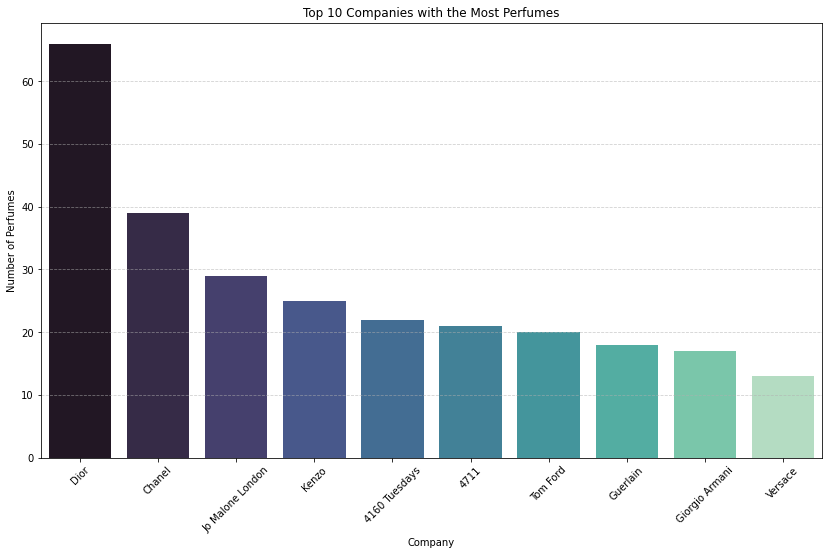

In [4]:
# Dior 과 Christian Dior 회사 합치기 (같은 회사이므로)
perfumes_raw['company'] = perfumes_raw['company'].replace(['Dior', 'Christian Dior'], 'Dior')

# 회사별 향수 개수 세기
company_counts_updated = perfumes_raw['company'].value_counts().head(10)

# 회사명 개수로 수직 그래프 그리기
plt.figure(figsize=(14, 8))
sns.barplot(y=company_counts_updated.values, x=company_counts_updated.index, palette='mako')
plt.title('Top 10 Companies with the Most Perfumes')
plt.ylabel('Number of Perfumes')
plt.xlabel('Company')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

##### 3-2. 향수 데이터셋에서 주요 향 구성요소의 빈도 탐색 및 시각화

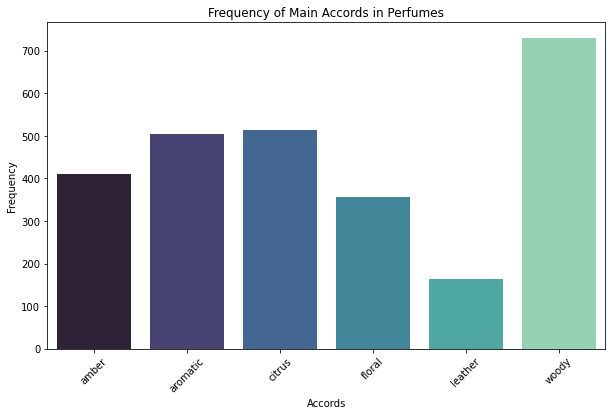

In [5]:
# 'main accords' 열에서 NaN 값을 가진 행을 제거하여 데이터 정제
cleaned_data = perfumes_raw.dropna(subset=['main accords'])

# 지정된 향의 빈도를 세는 함수 정의
def count_accords(df, accords):
    accord_counts = {accord: 0 for accord in accords}
    for accords_list in df['main accords']:
        try:
            # 문자열을 사전으로 변환
            accords_dict = json.loads(accords_list.replace("'", '"'))
            for accord in accords:
                if accord in accords_dict:
                    accord_counts[accord] += 1
        except json.JSONDecodeError:
            continue
    return accord_counts

# 계산할 주요 향의 목록을 정의
specified_accords = ["amber", "aromatic", "chypre", "citrus", "floral", "leather", "woody"]

# 정제된 데이터에서 지정된 향의 빈도를 계산
cleaned_accord_counts = count_accords(cleaned_data, specified_accords)

# 'Chypre' 향이 없는 경우 계산 결과에서 제거
if 'chypre' in cleaned_accord_counts:
    del cleaned_accord_counts['chypre']

# 주요 향의 빈도를 바 차트로 시각화
accords_names = list(cleaned_accord_counts.keys())
accords_values = list(cleaned_accord_counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=accords_names, y=accords_values, palette='mako')
plt.title('Frequency of Main Accords in Perfumes')
plt.xlabel('Accords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### 4. 전처리 하기
##### 4.1 향수 데이터 전처리 하기
- 'name' 열을 기준으로 중복 행 제거
- Main Accords, top/middle/base notes들 텍스트 한 군데('notes' 열 새로 생성)로 합하기
    - 향수 전처리 데이터를 'notes' 열 하나로 보기 위하여

In [17]:
perfumes_raw.info()    #크롤링 할 때 애초에 main accords, top/middle/base notes가 없는 데이터도 있어서 non-null이 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          1074 non-null   object
 1   company       1074 non-null   object
 2   image         1074 non-null   object
 3   for_gender    1074 non-null   object
 4   main accords  1045 non-null   object
 5   top notes     807 non-null    object
 6   middle notes  878 non-null    object
 7   base notes    807 non-null    object
 8   notes         900 non-null    object
dtypes: object(9)
memory usage: 75.6+ KB


In [18]:
destinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ranking      100 non-null    int64 
 1   city         100 non-null    object
 2   description  100 non-null    object
 3   City Mood    100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB


### 데이터 전처리
- 텍스트 데이터 전처리 함수화
- 함수로 지정해둔 것을 불러올 예정

In [11]:
# NLTK 데이터 다운로드 (최초 실행 시 한 번만 필요)
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sohtk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

* 텍스트 전처리
    - 소문자 변환
    - 불용어 제거
    - 어간 추출

In [19]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))
# 어간 추출기 설정
stemmer = PorterStemmer()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    
    # 불용어 제거 및 어간 추출
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    # 전처리된 단어들을 다시 하나의 문자열로 결합
    return ' '.join(words)

In [20]:
# 텍스트 전처리 전, notes 열에서 결측치가 있는 행은 제거하고 진행
# 결측치가 존재하는 경우, np.nan으로 결측치가 처리되어 float 타입으로 인식되어 전처리가 불가능함
perfumes = perfumes_raw.dropna(subset=['notes'])

In [21]:
# 데이터 프레임의 텍스트 열 전처리

# 향수 텍스트 열 전처리
text_perfume = 'notes'   # 텍스트 데이터가 있는 열의 이름 미리 지정
perfumes[text_perfume] = perfumes[text_perfume].apply(preprocess_text)

# 여행지 텍스트 열 전처리
text_city = 'City Mood'  # 텍스트 데이터가 있는 열의 이름 미리 지정
destinations[text_city] = destinations[text_city].apply(preprocess_text)

C:\Users\sohtk\AppData\Local\Temp\ipykernel_30532\1999258345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfumes[text_perfume] = perfumes[text_perfume].apply(preprocess_text)


- 텍스트 전처리 (TF-IDF)

In [22]:
# # TF-IDF 벡터화
# vectorizer = TfidfVectorizer()
# tfidf_perfume = vectorizer.fit_transform(perfumes[text_perfume])

# vectorizer = TfidfVectorizer()
# tfidf_city = vectorizer.fit_transform(destinations[text_city])

In [33]:
# 모든 텍스트 데이터에 대해 fit_transform 수행
vectorizer = TfidfVectorizer()
all_texts = perfumes['notes'].tolist() + destinations['City Mood'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# perfumes와 destinations의 TF-IDF 행렬 분리
tfidf_perfume = tfidf_matrix[:len(perfumes)]
tfidf_city = tfidf_matrix[len(perfumes):]

#### 5. 모덷링하기
- NMF (Non-negative Matrix Factorization)
- Cosine Similarity
- 함수화 해서 불러와줄 예정

##### 5.1 여행지 분위기 키워드 추출 (by. NMF)
##### 여행지 분위기 추출 라벨
- 팀원 셋이 임의적으로 분위기를 선정하여 추출함
    - **자연 경관**을 표현하는 형용사 : picturesque(그림 같은), peaceful(평화로운), grand(웅장한), tranquil(고요한), lush(푸르른), exquisite(황홀한)
    - **도시와 문화**를 표현하는 형용사 : vibrant(활기찬), bustling(번화한), traditional(전통적인), cultural(문화적인), unique(독특한), trendy(유행하는)
    - **휴양지**를 표현하는 형용사 : relaxing(편안한), romantic(낭만적인), luxurious(화려한), exotic(이국적인)
    - **모험과 액티비티**를 표현하는 형용사 : adventurous(모험적인), active(활발한)

### Non-negative Matrix Factorization (비음수 행렬 분해, NMF)
- Non-negative Matrix Factorization은 Matrix Factorization의 한 종류로, 분해된 행렬 \( P \)와 \( Q \)의 모든 요소가 비음수(0 또는 양수)라는 제약 조건이 있는 방법임
- 데이터가 자연수나 비음수로 구성되어 있을 때 유용함

- NMF는 다음과 같이 표현됨:

$$ V \approx W \cdot H $$

여기서 $V$는 원래의 행렬, $W$와 $H$는 비음수 행렬을 의미함 
- 이 제약 조건은 결과 행렬들이 해석 가능하고 의미 있는 잠재 요인을 가지도록 도와줌
- NMF는 텍스트 마이닝, 이미지 처리, 생물정보학 등의 다양한 분야에서 사용되고 있음

### Matrix Factorization과 NMF의 주요 차이점
   - Matrix Factorization은 행렬 요소에 비음수 제약이 없으며, 요소가 음수일 수 있음
   - Non-negative Matrix Factorization은 행렬 요소가 비음수여야 함
      - 우리 프로젝트의 경우, 여행지의 분위기를 담은 텍스트를 만들었기 때문에 특히나 요소가 비음수임
      - NMF는 비음수 제약으로 인해 결과가 더 해석 가능하고 의미 있는 패턴을 도출하는 데 유리하기 때문에 NMF를 선정

In [34]:
# 여행지 분위기 추출 함수 (여러 주제, NMF 활용)
def extract_destination_moods(tfidf_matrix, destinations, n_topics=18):
    # NMF를 사용하여 주제 모델링
    nmf_model = NMF(n_components=n_topics, random_state=1)
    W = nmf_model.fit_transform(tfidf_matrix)
    
    # 각 주제를 미리 정의된 레이블로 매핑
    mood_labels = ['picturesque', 'peaceful', 'grand', 'tranquil', 'lush', 'exquisite', 
                    'vibrant', 'bustling', 'traditional', 'cultural', 'unique', 'trendy', 'relaxing', 
                    'romantic', 'luxurious', 'exotic', 'adventurous', 'active']
    topic_to_mood = {i: mood_labels[i] for i in range(n_topics)}
    
    # 각 여행지에 대해 상위 3개의 주제를 추출하여 분위기 매핑
    top_topics = np.argsort(W, axis=1)[:, -3:]
    top_moods = [[topic_to_mood[topic] for topic in topics] for topics in top_topics]
    
    destinations['keyword'] = top_moods
    
    return destinations

##### 5.2 키워드와 향수 노트 유사도 측정

In [35]:
# 추천 시스템 
def recommend_perfumes_for_destinations(destinations, tfidf_city, tfidf_perfume, perfumes, top_n=5):
    recommendations = []
    for i, destination in destinations.iterrows():
        destination_vector = tfidf_city[i].reshape(1, -1)
        cosine_sim = cosine_similarity(destination_vector, tfidf_perfume).flatten()
        top_perfume_indices = cosine_sim.argsort()[-top_n:][::-1]  # 상위 n개 향수 추천
        recommended_perfumes = [perfumes.iloc[idx]['name'] for idx in top_perfume_indices]
        recommendations.append(recommended_perfumes)
    
    destinations['recommendation'] = recommendations
    return destinations

In [36]:
# 여행지 분위기 추출
destinations = extract_destination_moods(tfidf_city, destinations, n_topics=18)
keyword_check = destinations.loc[:, ['city', 'keyword']]
# keyword_check.to_csv('check_keyword.csv', index=False)
keyword_check.head(3)

c:\Users\sohtk\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,city,keyword
0,London,"[traditional, cultural, exotic]"
1,Paris,"[lush, luxurious, exquisite]"
2,New York,"[luxurious, relaxing, exotic]"


In [37]:
recommendations = recommend_perfumes_for_destinations(destinations, tfidf_city, tfidf_perfume, perfumes, top_n=5)
recommend_check = recommendations.loc[:, ['city', 'keyword', 'recommendation']]
# recommend_check.to_csv('recommend_check.csv', index=False)
recommend_check.head(3)

,city,keyword,recommendation
0,London,"[traditional, cultural, exotic]","[Pour Femme Dylan Blue Versace Versace, Le Par..."
1,Paris,"[lush, luxurious, exquisite]","[M. Balode Florascent, Tobacco Pod For the Sce..."
2,New York,"[luxurious, relaxing, exotic]","[OR/18 A. N. OTHER, Garden Roses Burberry, DKN..."
